Resolución del problema **SUMA DE SUBCONJUTOS** utilizando deap
https://deap.readthedocs.io/en/master/

En primer lugar, debemos intalar la librería:

In [2]:
!pip install deap

     |████████████████████████████████| 163kB 2.8MB/s 


**Importamos las liberías necesarias:**
1. random: números pseudoaleatorios
2. numpy: arrays
3. maplotlib.pyplot: visualizar los resultados
4. deap.base: incluye las clases base de deap. En concreto dos son importantes en nuestro ejemplo, base.Fitness y base.Toolbox.
5. deap.creator: permite crear clases nuevas.
6. deap.tools: herramientas para implementar los algoritmos genéticos: operadores genéticos (selección, cruce y mutación), hallofFame, estadística, registro de evolución, etc.
7. deap.alorihtms: incluye implementaciones completas de algoritmos genéticos, nosotros vamos a utilizar eaSimple.

In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt    
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

**Datos del problema**
* LIMITE_INF y LIMITE_SUP: Límites de los valores del conjunto.
* TAM_CONJUNTO: Número de elementos del conjunto.
* SUMA_OBJETIVO: Suma objetivo del subconjunto seleccionado. 
* CONJUNTO: Array que contiene el conjunto de valores.

In [29]:
random.seed(42) # ajustamos aquí la semilla para que todos tengamos los mismos valores
LIMITE_INF, LIMITE_SUP = 0, 30
TAM_CONJUNTO = 30 
SUMA_OBJETIVO = 333
CONJUNTO = np.array(random.sample(range(LIMITE_INF, LIMITE_SUP), TAM_CONJUNTO))
print(CONJUNTO)
print("Valor máximo que puede tener SUMA_OBJETIVO", sum(CONJUNTO)) 

[20  3  0 23  8  7 24  4 28 17  2 18 13  1 27 16 21 29 25  9 15 11 12  5
  6 22 26 10 14 19]
Valor máximo que puede tener SUMA_OBJETIVO 435


Creamos la clase que define el fitness de los individuos **FitnessMulti**. Este paso en la mayoría de los problemas será muy parecido. Siempre tendremos que heredar de base.Fitness. El atributo **weights** nos dice el número de objetivos de nuestro problema y el tipo (-1.0 para minimizar y 1.0 para maximizar). En este caso es un problema de dos objetivos ambos de  **minimización**.

In [0]:
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0)) 

Ahora creamos la "plantilla" del individuo, el cromosoma. El individuo será una lista (hereda los métodos de la lista), pero tiene el atributo FitnessMulti creado en la línea anterior. Representar los individuos como lista nos servirá en una gran cantidad de casos (lista de variables del problema).

In [0]:
creator.create("Individual", list, fitness=creator.FitnessMulti)

El objeto toolbox funciona como una "caja de herramientas" donde **debemos registrar operaciones que nos hacen falta en el algoritmo genético**. Cosas que debemos registrar:
1. Funciones para crear tanto individuos aleatorios como la población inicial.
2. Operadores genéticos (selección, cruce y mutación).
3. La función de evaluación.

In [0]:
toolbox = base.Toolbox()

Comenzamos registrando las funciones que nos permiten generar individuos aleatorios y la población incial. Empezamos por muestra aleatorias de individuos (cromosoma). **No es el individuo completo ya que no tiene el  atributo fitness**.
Utilizamos la función random.randint para generar números binarios https://docs.python.org/3/library/random.html

In [0]:
def crea_individuo(size):
    return [random.randint(0, 1) for i in range(size)]
toolbox.register("attr", crea_individuo, TAM_CONJUNTO)

Podemos ver la muestra que se crea:

In [14]:
print(toolbox.attr())

[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]


Generamos individuos aleatorios y población inicial

In [0]:
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

Vamos a ver cómo funcionan con un par de ejemplos:

In [17]:
ind = toolbox. individual() # creamos un individuo aleatorio
print(ind)
print(ind.fitness.values) # en fitness.values se guardará el fitness

[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
()


**Definimos la función objetivo:**
1.   Seleccionamos del conjunto original aquellas posiciones en las que individuo tiene un 1.
2.   Sumamos los elementos seleccionados.
3.   Calculamos la diferencia.
4.   Calculamos el número de elementos.
5.   Comprobamos las restricciones. Si no se cumplen, pena de muerte.
6.   Devolvemos el fitness para cada objetivo.

**IMPORTANTE:** Siempre debemos devolver una tupla!! 

**IMPORTANTE:** Si aplicamos la pena de muerte tiene que ser a los dos objetivos!!

In [0]:
def funcion_objetivo(individuo, suma_objetivo):
    subconjunto = CONJUNTO[np.array(individuo) == 1]
    suma_subconjunto = np.sum(subconjunto)
    diferencia = suma_objetivo - suma_subconjunto
    n_elementos = sum(individuo)
    if diferencia < 0: # nos pasamos
        return 10000, 10000 # pena de muerte    
    if n_elementos == 0: # no se selecciona ninguna elemento
        return 10000, 10000 # pena de muerte
    return n_elementos, diferencia

**Registro de operadores genéticos:**

1.   Cruce de dos puntos.
2.   Mutación bitflip.
3.   Selección mediante torneo, tamaño del torneo igual a 3 (suele ir bien para la mayoría de problemas). Si tenemos muchas variables podemos probar a aumentarlo un poco.
4.   Función de evaluación.

In [0]:
toolbox.register("mate", tools.cxTwoPoint) 
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) 
toolbox.register("select", tools.selNSGA2) 
toolbox.register("evaluate", funcion_objetivo, suma_objetivo=SUMA_OBJETIVO) 

Función para representar el **frente de Pareto**.

In [0]:
def plot_frente(pareto):
    lista_fitness1 = list()
    lista_fitness2 = list()
    for ind in pareto: # recorremos los elementos del Pareto
        lista_fitness1.append(ind.fitness.values[0])
        lista_fitness2.append(ind.fitness.values[1])    
    plt.scatter(lista_fitness1, lista_fitness2, marker="+", color="b", s=50)    
    plt.xlabel("Elementos")
    plt.ylabel("Diferencias")
    plt.grid(True)
    plt.xlim([0, 17])
    plt.ylim([-20, 350])
    plt.legend(["Frente de Pareto"], loc="upper right")
    plt.savefig("Pareto_conjunto.eps", dpi = 300)

En el main configuramos el algoritmo genético. 

Ajuste de los operadores genéticos:
* *CXPB:* probabilidad de cruce
* *MUTPB:* probabilidad de mutación

Número de generaciones:
* *NGEN:* número de generaciones

El objeto **hof** almacena el mejor individuo encontrado a lo largo de las generaciones. Le tenemos que p

El objeto **stats** calcula las estadísticas de la población en cada generación. Cuando se define le tenemos que decir sobre qué se va a calcular las estadística. A continuación, se deben registrar las funciones estadísticas que se van a aplicar.

El objeto **logbook** almacena todas las estadísticas calculadas por generación en un solo objeto.

Algoritmo **eaMuPlusLambda** parámetros que tenemos que pasar:
* poblacion (obligatorio)
* toolbox (obligatorio)
* mu, número de inviduos de la población (obligatorio)
* lambda, número de individuos a seleccionar para pasar la siguiente generación. Si no queremos que la población cambie de tamaño mu=lamnda. (obligatorio)
* probabilidad de cruce (obligatorio)
* probabilidad de mutación (obligatorio)
* número de generaciones (obligatorio)
* objeto de estadísticas (opcional)
* objeto hallofFame que almacena el mejor individuo (opcional)
* Si queremos que se muestre las estádisticas en cada generación, verbose = True (opcional)

In [0]:
def main():
    CXPB, MUTPB, NGEN = 0.7, 0.3, 200
    MU, LAMBDA = 300, 300
    pop = toolbox.population(MU)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()  
    pareto = tools.ParetoFront() 
    pop, logbook = algorithms.eaMuPlusLambda(pop , toolbox , mu=MU, lambda_=LAMBDA, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=pareto,  verbose=True)
    return pop, logbook, pareto

Lanzamos el algoritmo y mostramos los resultados.

gen	nevals	avg    	std    	min	max  
0  	300   	130.763	810.686	3  	10000
1  	300   	59.3583	59.5023	1  	250  
2  	300   	56.2517	59.9544	1  	258  
3  	300   	54.3833	62.8947	1  	258  
4  	300   	48.205 	58.7115	0  	253  
5  	300   	50.005 	63.1836	0  	269  
6  	300   	46.055 	61.0986	0  	269  
7  	300   	44.3417	61.1715	0  	269  
8  	300   	44.7017	62.8203	0  	284  
9  	300   	42.49  	61.3017	0  	284  
10 	300   	42.1733	61.6398	0  	284  
11 	300   	39.3867	59.8779	0  	284  
12 	300   	36.1367	57.8804	0  	284  
13 	300   	37.825 	61.8125	0  	284  
14 	300   	35.6067	58.5265	0  	284  
15 	300   	36.075 	60.4806	0  	298  
16 	300   	36.7367	61.7422	0  	298  
17 	300   	30.32  	54.4774	0  	298  
18 	300   	35.2067	58.9851	0  	298  
19 	300   	34.2767	59.4664	0  	298  
20 	300   	30.8883	52.9643	0  	298  
21 	300   	32.7917	53.8045	0  	298  
22 	300   	35.5567	53.4055	0  	298  
23 	300   	34.055 	50.4115	0  	318  
24 	300   	31.915 	48.6029	0  	318  
25 	300   	31.4633	40.7375	0  	318  
2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


199	300   	14.5167	36.0593	0  	304  
200	300   	14.5167	36.0593	0  	304  


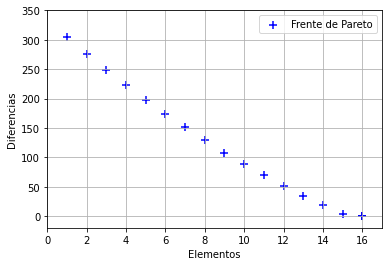

In [31]:
if __name__ == "__main__":    
    pop, log, pareto = main()
    plot_frente(pareto)